# Project: Recognizing Traffic Signs Using Deep Learning
### Scope: Classifier: VGGNet
##### Author: Ashish Panchal (epababl03.ashishp@iima.ac.in)

In [19]:
import numpy as np
import pandas as pd
import sys
import os
import pickle as p
import cv2
import seaborn as sns

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

sys.path.insert(2, os.path.abspath('../src/data'))
from datapreprocessor import preprocess

In [2]:
#Load stored data

#No. of classes
%store -r n_classes

# class labels
%store -r signs

#Final preprocessed Training Dataset
%store -r X_train_preprocessed
%store -r y_train_final

#Final preprocessed Test Dataset
%store -r X_test_preprocessed
%store -r y_test


#Final preprocessed Validation Dataset
%store -r X_valid_preprocessed 
%store -r y_valid

EPOCHS = 30
BATCH_SIZE = 64
DIR = '../Saved_Models/VGGNet'

### 1.2. VGGNet

VGGNet was first introduced in 2014 by K. Simonyan and A. Zisserman from the University of Oxford in a paper called Very Deep Convolutional Networks for Large-Scale Image Recognition. They were investigating the convolutional network depth on its accuracy in the large-scale image recognition setting. Their main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers.

__VGGNet architecture:__
    
The original VGGNet architecture has 16-19 layers, but I've excluded some of them and implemented a modified version of only 12 layers to save computational resources.

This ConvNet follows these steps:

Input => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected => ReLU => FullyConnected


__Layer 1 (Convolutional):__ The output shape should be 32x32x32.

__Activation.__ Your choice of activation function.

__Layer 2 (Convolutional):__ The output shape should be 32x32x32.

__Activation.__ Your choice of activation function.

__Layer 3 (Pooling)__ The output shape should be 16x16x32.

__Layer 4 (Convolutional):__ The output shape should be 16x16x64.

__Activation.__ Your choice of activation function.

__Layer 5 (Convolutional):__ The output shape should be 16x16x64.

__Activation.__ Your choice of activation function.

__Layer 6 (Pooling)__ The output shape should be 8x8x64.

__Layer 7 (Convolutional):__ The output shape should be 8x8x128.

__Activation.__ Your choice of activation function.

__Layer 8 (Convolutional):__ The output shape should be 8x8x128.

__Activation.__ Your choice of activation function.

__Layer 9 (Pooling)__ The output shape should be 4x4x128.

__Flattening:__ Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

__Layer 10 (Fully Connected):__ This should have 128 outputs.

__Activation.__ Your choice of activation function.

__Layer 11 (Fully Connected):__ This should have 128 outputs.

__Activation.__ Your choice of activation function.

__Layer 12__ (Fully Connected): This should have 43 outputs.    

In [3]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)

        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    def evaluate_loss(self, X_data, y_data, BATCH_SIZE=64):
        #print('evaluate_loss:',type(X_data))
        num_examples = len(X_data)
        total_loss = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            loss = sess.run(self.loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_loss += (loss * len(batch_x))
        return total_loss / num_examples

## 2. Model Training and Evaluation

In this step, we will train our model using normalized_images, then we'll compute softmax cross entropy between logits and labels to measure the model's error probability.

x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [4]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

In [5]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [6]:
lenet_data_frame = pd.read_csv("../reports/cnn_data.csv")

In [7]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
one_hot_y_valid = tf.one_hot(y_valid, 43)
normalized_images = X_train_preprocessed
y_train = y_train_final

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})


        #validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        #print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
        #model_acc_df.loc[i, 'VGGnet_acc'] = (validation_accuracy*100)
        training_accuracy = VGGNet_Model.evaluate(normalized_images, y_train)
        training_loss = VGGNet_Model.evaluate_loss(normalized_images, y_train)
        
        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        validation_loss = VGGNet_Model.evaluate_loss(X_valid_preprocessed, y_valid)
        
        print("EPOCH {} : Training Accuracy = {:.3f}%".format(i+1, (training_accuracy*100)), " Training Loss = {:.3f}%".format(i+1, (training_loss*100)))
        #print("EPOCH {} : Training Loss = {:.3f}%".format(i+1, (training_loss*100)))
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)), " Validation Loss = {:.3f}%".format(i+1, (validation_loss*100)))
        #print("EPOCH {} : Validation Loss = {:.3f}%".format(i+1, (validation_loss*100)))
        print('')
        lenet_data_frame.loc[i, 'EPOCH'] = i+1
        lenet_data_frame.loc[i, 'VGGNet_Train_Acc'] = (training_accuracy*100)
        lenet_data_frame.loc[i, 'VGGNet_Train_Loss'] = (training_loss*100)
        lenet_data_frame.loc[i, 'VGGNet_Valid_Acc'] = (validation_accuracy*100)
        lenet_data_frame.loc[i, 'VGGNet_Valid_Loss'] = (validation_loss*100)
        
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")
    lenet_data_frame.to_csv('../reports/cnn_data.csv', index = False, header=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Training...

EPOCH 1 : Training Accuracy = 23.489%  Training Loss = 1.000%
EPOCH 1 : Validation Accuracy = 24.694%  Validation Loss = 1.000%

EPOCH 2 : Training Accuracy = 46.984%  Training Loss = 2.000%
EPOCH 2 : Validation Accuracy = 46.327%  Validation Loss = 2.000%

EPOCH 3 : Training Accuracy = 67.960%  Training Loss = 3.000%
EPOCH 3 : Validation Accuracy = 67.075%  Validation Loss = 3.000%

EPOCH 4 : Training Accuracy = 81.666%  Training Loss = 4.000%
EPOCH 4 : Validation Accuracy = 80.522%  Validation Loss = 4.000%

EPOCH 5 : Training Accuracy = 88.022%  Training Loss = 5.000%
EPOCH 5 : Validation Accuracy = 89.683%  Validation Loss = 5.000%

EPOCH 6 : Training Accuracy = 91.096%  Training Loss = 6.000%
EPOCH 6 : Validation Accuracy = 9

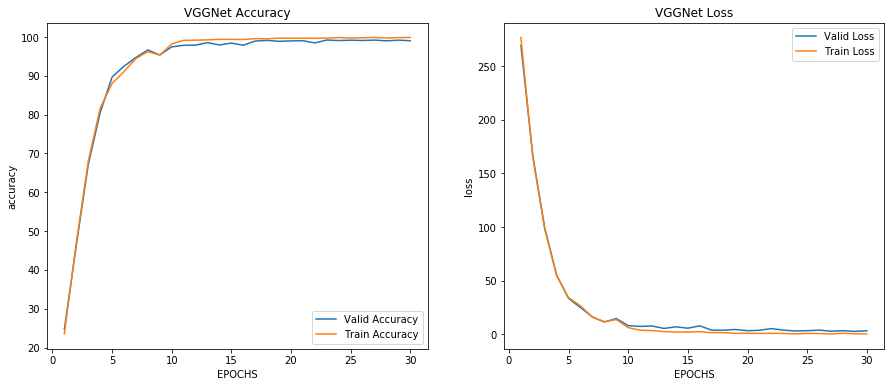

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharex=True)
# Draw line plot
sns.lineplot(x='EPOCH',y='VGGNet_Valid_Acc', data=lenet_data_frame,ax=axes[0],label='Valid Accuracy')
sns.lineplot(x='EPOCH',y='VGGNet_Train_Acc', data=lenet_data_frame, ax=axes[0], label='Train Accuracy')
axes[0].set_title('VGGNet Accuracy')
axes[0].legend()

sns.lineplot(x='EPOCH',y='VGGNet_Valid_Loss', data=lenet_data_frame,ax=axes[1], label='Valid Loss')
sns.lineplot(x='EPOCH',y='VGGNet_Train_Loss', data=lenet_data_frame, ax=axes[1], label='Train Loss')
axes[1].set_title('VGGNet Loss')
axes[1].legend()
#Set common labels
axes[0].set_xlabel('EPOCHS')
axes[1].set_xlabel('EPOCHS')
axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('loss')
plt.savefig('../plots/classifier/vggnet/perf_curve_v1.png')
plt.show()

## 3.  Testing the Model using the Test Set
Now, we'll use the testing set to measure the accuracy of the model over unknown examples.

In [9]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ../Saved_Models/VGGNet/VGGNet
Test Accuracy = 97.2%


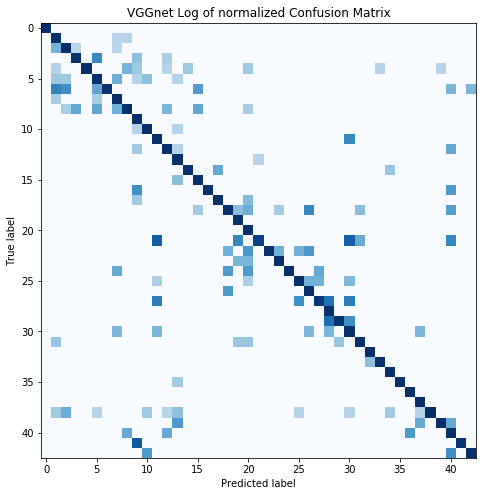

In [11]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('VGGnet Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('../plots/classifier/vggnet/VGGNet_confusion_mat_v1.png')
plt.show()

__Observation:__

1. 

2. 

## 4.Testing the LeNet Model on New Images

In [12]:
### Loading and resizing new test images
new_test_images = []
path = '../data/traffic_sign_images/'
for image in sorted(os.listdir(path)):
    print('Reading:', path+image)
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17, 1,  14, 30, 25, 29, 11, 8,  31, 31, 30, 4, 1, 2, 27, 18]
print("Number of new testing examples: ", len(new_test_images), 'Signs:', len(new_IDs))

Reading: ../data/traffic_sign_images/001.jpg
Reading: ../data/traffic_sign_images/002.jpg
Reading: ../data/traffic_sign_images/003.jpg
Reading: ../data/traffic_sign_images/004.jpg
Reading: ../data/traffic_sign_images/005.jpg
Reading: ../data/traffic_sign_images/006.jpg
Reading: ../data/traffic_sign_images/007.jpg
Reading: ../data/traffic_sign_images/008.jpg
Reading: ../data/traffic_sign_images/009.jpg
Reading: ../data/traffic_sign_images/010.jpg
Reading: ../data/traffic_sign_images/011.jpg
Reading: ../data/traffic_sign_images/012.jpg
Reading: ../data/traffic_sign_images/013.jpg
Reading: ../data/traffic_sign_images/014.jpg
Reading: ../data/traffic_sign_images/015.jpg
Reading: ../data/traffic_sign_images/016.jpg
Reading: ../data/traffic_sign_images/017.jpg
Reading: ../data/traffic_sign_images/018.jpg
Reading: ../data/traffic_sign_images/019.jpg
Reading: ../data/traffic_sign_images/020.jpg
Number of new testing examples:  20 Signs: 20


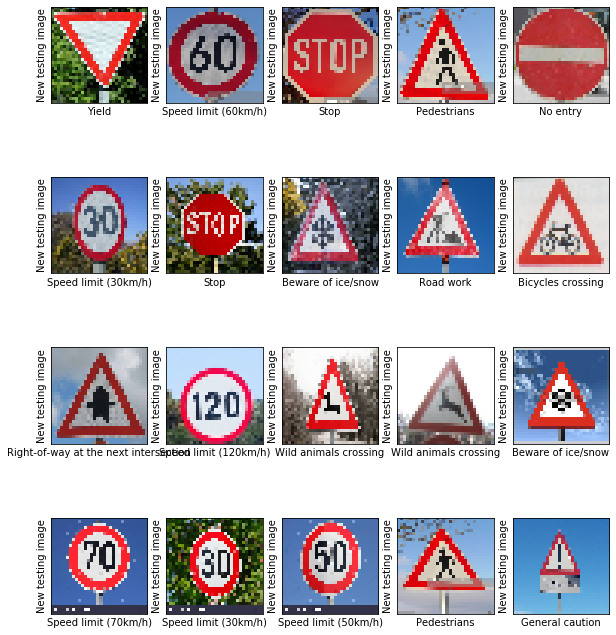

In [13]:
plt.figure(figsize=(10, 12))
for i in range(len(new_test_images)):
    plt.subplot(4, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
#plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [14]:
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from ../Saved_Models/VGGNet/VGGNet
New Images Test Accuracy = 75.0%


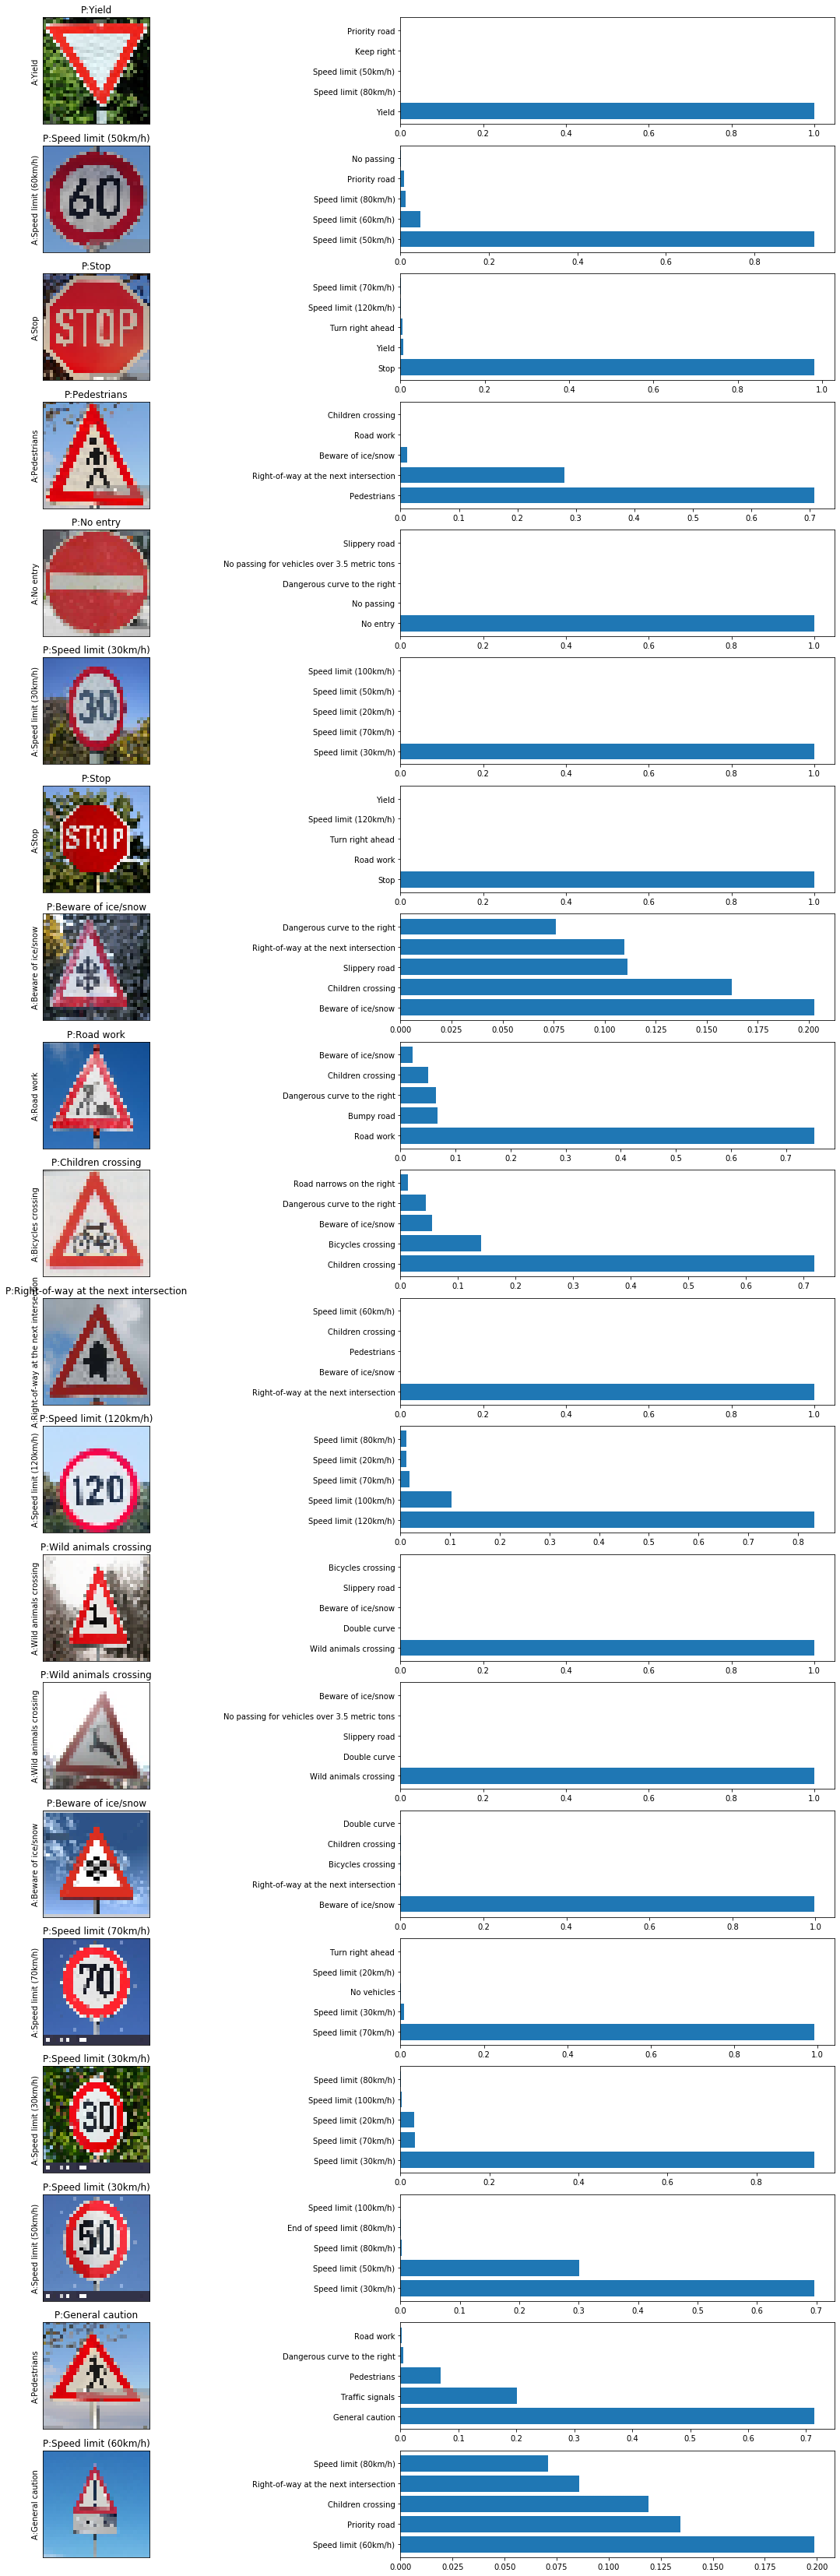

In [16]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
#print('new_test_images_preprocessed', new_test_images_preprocessed.shape[0])
for i in enumerate(new_test_images_preprocessed):
    #print('new_IDs[i[0]]:',new_IDs[i[0]])
    #print('np.asarray(y_pred[i[0]])[0]:',np.asarray(y_pred[i[0]])[0])
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy +=1
print("New Images Test Accuracy = {:.1f}%".format((test_accuracy/new_test_images_preprocessed.shape[0])*100))

plt.figure(figsize=(22, 60))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    actual = signs[new_IDs[i]]
    #print('LABEL:',actual)
    #plt.title('Actual:'+actual+'\nPredicted: '+signs[y_pred[i][0]])
    plt.title('P:'+signs[y_pred[i][0]])
    plt.ylabel('A:'+actual)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.savefig('../plots/classifier/vggnet/vggnet_new Image_acc.png')
plt.show()